In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC 

# Fraud Detection

Este notebook pretende encontrar un modelo que permita detectar un posible fraude.

● Step: representa una unidad de tiempo donde 1 step equivale a 1 hora

● type: tipo de transacción en línea

● amount: el importe de la transacción

● nameOrig: cliente que inicia la transacción

● oldbalanceOrg: saldo antes de la transacción

● newbalanceOrig: saldo después de la transacción

● nameDest: destinatario de la transacción

● oldbalanceDest: saldo inicial del destinatario antes de la transacción

● newbalanceDest: el nuevo saldo del destinatario después de la transacción

● isFraud: transacción fraudulenta

## Exploración Inicial de Datos

En esta exploración inicial revisamos que variables y qué tipo de variable tiene el dataset, cuantos valores nulos hay para cada variable.

In [6]:
df = pd.read_csv('./data/fraud_detection.csv')

In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Vemos que tenemos cinco variables categóricas: "type", "nameOrig", "nameDest", "isFraud", "isFlaggedFraud" (Estas dos últimas, si bien están representadas por números, son variables categóricas y es importante tenerlo en cuenta si queremos más adelante hacer cuadros de correlación para usar el coeficiente correcto). Más adelante vemos como haremos el tratamiento de cada una de ellas. 

In [9]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

No hay valores nulos. 

In [10]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


ploteamos un stacked barplot para poder ver la correlación entre la variable categórica "type" y la variable target. 

In [11]:
CrosstabResult= pd.crosstab(index=df['type'], columns=df['isFraud'])
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'CASH_IN'),
  Text(1, 0, 'CASH_OUT'),
  Text(2, 0, 'DEBIT'),
  Text(3, 0, 'PAYMENT'),
  Text(4, 0, 'TRANSFER')])

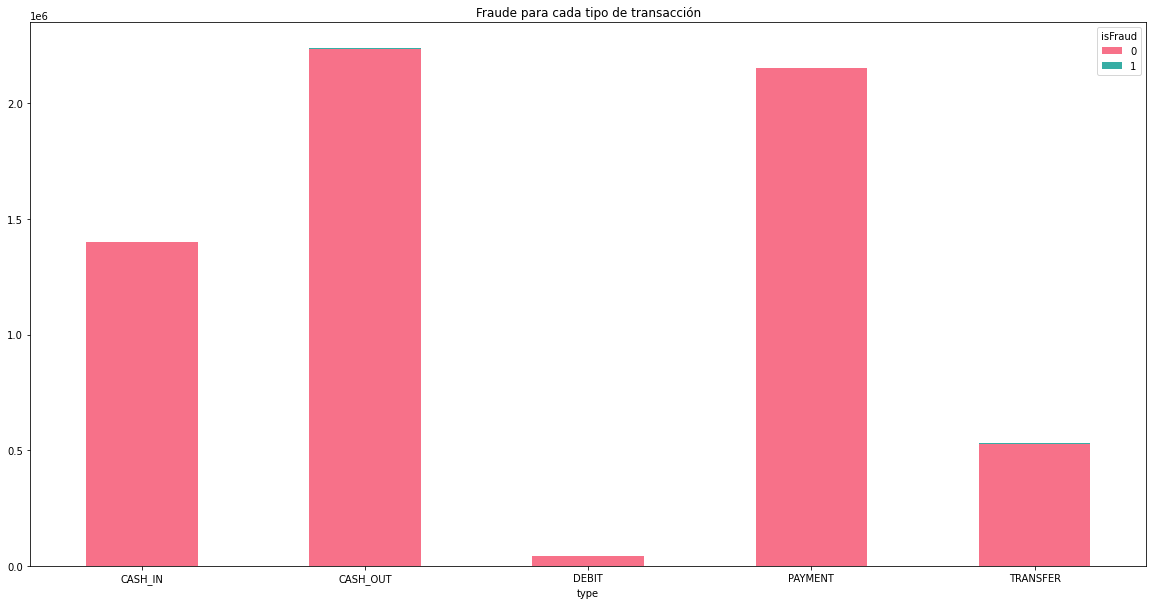

In [12]:
CrosstabResult.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("husl", 2)),
                    figsize = (20,10))

plt.title('Fraude para cada tipo de transacción')
plt.xticks(rotation=0, ha='center')

La primera conclusión es que las clases están desvalanceadas, por lo tanto, vamos a tener que hacer un oversampling o undersampling. La segunda conslusión es que encontramos fraude sólo en las categorías Cash_out y Transfer. 

<AxesSubplot:xlabel='type', ylabel='isFraud'>

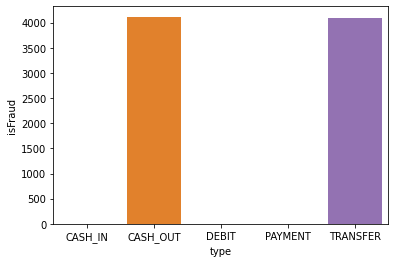

In [47]:
t = pd.DataFrame(df.groupby(by=df['type'])['isFraud'].sum())
sns.barplot(data=t,x=t.index, y='isFraud')

En esta gráfica podemos verlo mucho más claro.

Podemos hacer algunas gráficas para ver cómo se comportan las variables con la variable target y entre si.

Text(0, 0.5, 'isFraud')

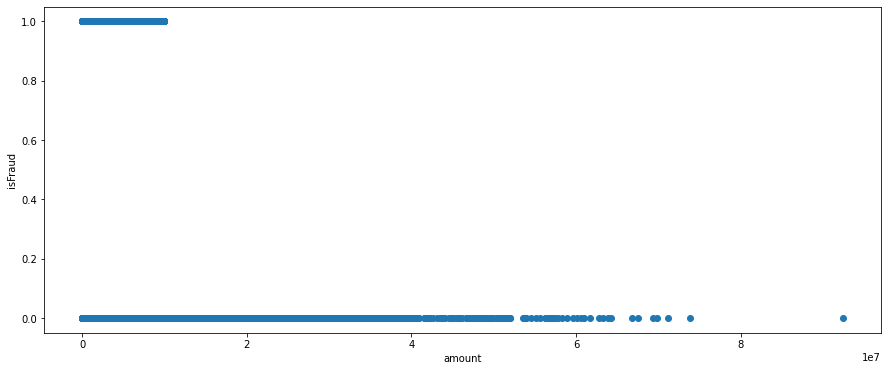

In [51]:
plt.figure(figsize=(15,6))
plt.scatter(x='amount',y='isFraud',data=df)
plt.xlabel('amount')
plt.ylabel('isFraud')

Esta gráfica es interesante porque podemos ver que los fraudes se dan en cantidades no muy grandes de dinero.

Text(0, 0.5, 'type')

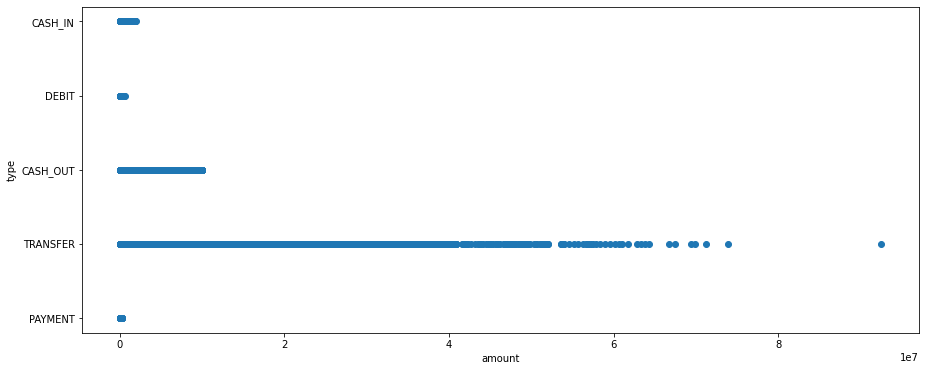

In [54]:
plt.figure(figsize=(15,6))
plt.scatter(x='amount',y='type',data=df)
plt.xlabel('amount')
plt.ylabel('type')

En esta gráfica vemos que las cantidades de dinero mas pequeñas se mueven en payments, cash_out, debit y cash_in; la que más se mueve de estas es cash_out junto con Transfer que son los dos tipos donde más suceden fraudes. 

Text(0, 0.5, 'step')

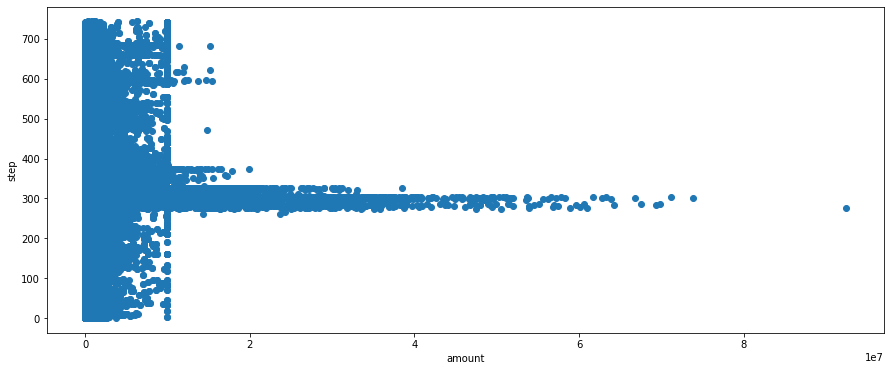

In [55]:
plt.figure(figsize=(15,6))
plt.scatter(x='amount',y='step',data=df)
plt.xlabel('amount')
plt.ylabel('step')

Acá podemos observar que para las mayores cantidades de dinero el valor de step es aproximandamente 300 -350. Lo que quiere decir que no sostienen una relación lineal como uno podría imaginar. También puede suceder que los steps por encima de 400 sean casos de procedimientos atípicos y que en 300 sea un techo de "normalidad". 

Calculamos el coeficiente de Kendall para analizar la correlación entre las variables numéricas y la variable Target (categórica).

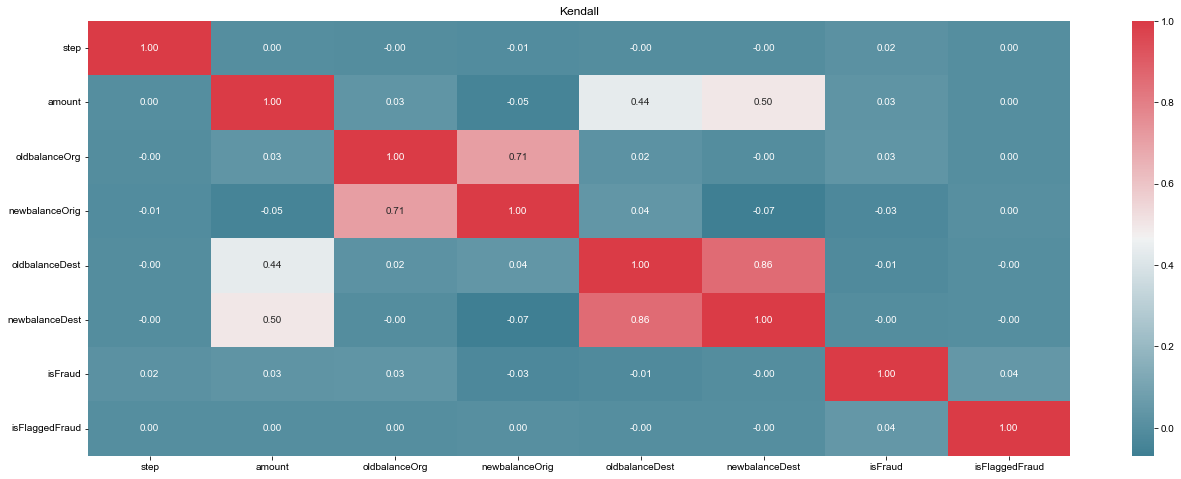

In [57]:
fig, axes = plt.subplots(1,1,figsize=(22,8))

tau = df.corr(method='kendall')
axes.set_title("Kendall")
sns.heatmap(tau, cmap=sns.diverging_palette(220,10,as_cmap=True),annot=True,fmt=".2f")
sns.set(font_scale=0.9)

La variable "isFraud" tiene correlaciones muy bajas con las variables numéricas. En ese caso es preferible dejarlas todas antes de descartar alguna y ver como se comporta el modelo. Quizás lo conveniente es usar PCA y mantener los componentes que mantengan un 90% de la varianza. 

## Codificiación Variables Categóricas

De las 5 variables categóricas, sólo codificamos "type". Las variables categóricas relacionadas con nombres de cuentas las dropeamos y nuestra variable target "isFraud" la dejamos como está. 

Hacemos un One Hot Encoding para Type. 

In [13]:
type_new = pd.get_dummies(df['type'])
df = pd.concat([df,type_new],axis=1)

In [14]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


Armamos nuestro X e y para pasar al balanceo de Clases.

In [15]:
X = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'CASH_IN', 
      'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']]
y = df['isFraud']

In [16]:
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [17]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

## Balanceo de Clases

Revisamos que cantidad de datos tenemos para cada clase

In [18]:
fraud_counts = y.value_counts()
print(fraud_counts)

0    6354407
1       8213
Name: isFraud, dtype: int64


Dado que el dataset es bastante amplio y la diferencia entre las clases es bastante, creo que lo mejor es hacer un undersampling. Con esto disminuímos la cantidad de muestras y evitamos que se ponga 'raro' el dataset al querer equiparar las muestras minoritarias con las mayoritarias.

Dividimos el dataset en train y test para luego aplicar el undersampling.

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2, stratify=y)

In [115]:
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (5090096, 11)
Testeo: (1272524, 11)

Clases train:
0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Clases test:
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


In [116]:
from imblearn.under_sampling import RandomUnderSampler

undersampler=RandomUnderSampler(sampling_strategy='majority');

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_us.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
0    6570
1    6570
Name: isFraud, dtype: int64

Composición del test set:
0    1270881
1       1643
Name: isFraud, dtype: int64


### PCA

Teniendo ya nuestro dataset balanceado, aplicamos PCA para reducir dimensiones y mantener el 90% de la varianza. 

In [117]:
scaler = StandardScaler()
scaler_x = scaler.fit(X_train_us)
x_train_us_scaled = scaler_x.transform(X_train_us)
x_test_us_scaled = scaler_x.transform(X_test)

In [118]:
pca = PCA(n_components=0.9, random_state=2).fit(x_train_us_scaled)
x_train_us_pca = pca.transform(x_train_us_scaled)
x_test_us_pca = pca.transform(x_test_us_scaled)

In [119]:
x_train_us_pca.shape[1]

7

Pasamos de tener 11 variables a quedarnos con 7 componentes principales.

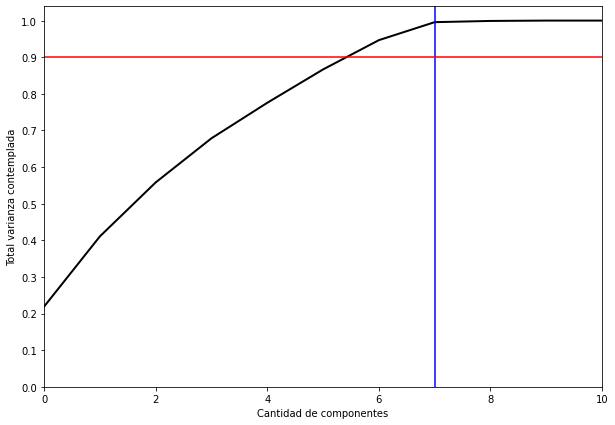

In [120]:
pca_2 = PCA(n_components=11, random_state=2).fit(x_train_us_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 10)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(7, c='b')
plt.axhline(0.9, c='r')
plt.show();

Con 7 componentes nos quedamos con un poco más del 90%. Veamos como se comportan los modelos.

## MODELOS

### 1. Regresión Logística + Lasso

In [121]:
rg = SGDClassifier(loss = 'log', l1_ratio=0.02, verbose=1, penalty='l1', max_iter=10000)
rg.fit(x_train_us_pca, y_train_us)

-- Epoch 1
Norm: 56.59, NNZs: 6, Bias: -9.208205, T: 13140, Avg. loss: 1.498324
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 59.09, NNZs: 7, Bias: -9.810058, T: 26280, Avg. loss: 0.666214
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 59.22, NNZs: 7, Bias: -7.642382, T: 39420, Avg. loss: 0.434524
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 59.52, NNZs: 7, Bias: -7.599527, T: 52560, Avg. loss: 0.465639
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 59.58, NNZs: 7, Bias: -7.496767, T: 65700, Avg. loss: 0.430395
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 59.55, NNZs: 7, Bias: -7.110062, T: 78840, Avg. loss: 0.364344
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 59.63, NNZs: 7, Bias: -6.770128, T: 91980, Avg. loss: 0.360365
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 59.57, NNZs: 7, Bias: -7.084565, T: 105120, Avg. loss: 0.396059
Total training time: 0.03 seconds.
-- Epoch 9
Norm: 59.61, NNZs: 7, Bias: -6.511514, T: 118260, Avg. loss: 0.35769

SGDClassifier(l1_ratio=0.02, loss='log', max_iter=10000, penalty='l1',
              verbose=1)

Calculamos el intercept y el slope para determinar bordes de desición.

In [122]:
intercept = -(rg.intercept_/rg.coef_[0][1])
print(intercept)

slope = -(rg.coef_[0][0]/ rg.coef_[0][1])
print(slope)

[2.6320366]
-1.851964538894919


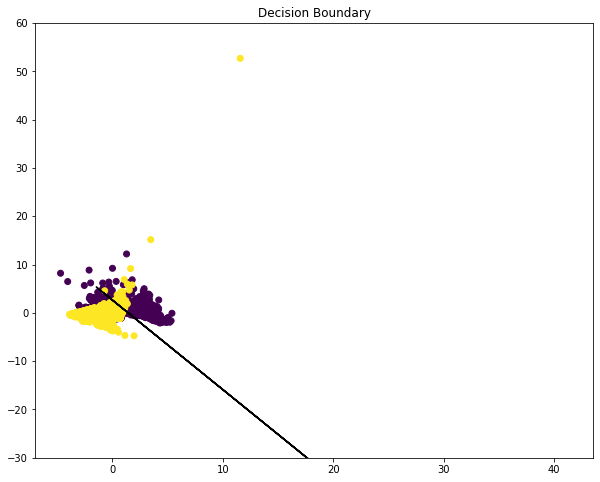

In [123]:
plt.figure(figsize=(10,8))
plt.scatter(x_train_us_pca[:, 2], x_train_us_pca[:, 3], c=y_train_us[:])
y_vals = intercept + (slope * x_train_us_pca[:, 0])
plt.plot(x_train_us_pca[:, 0], y_vals, c="k")
plt.title('Decision Boundary')
plt.ylim((-30, 60))
plt.show()

In [124]:
pred = rg.predict(x_test_us_pca)

In [125]:
precision = precision_score(y_test, pred)
precision

0.004964524547382157

In [126]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87   1270881
           1       0.00      0.89      0.01      1643

    accuracy                           0.77   1272524
   macro avg       0.50      0.83      0.44   1272524
weighted avg       1.00      0.77      0.87   1272524



Probemos ahora con Ridge

In [127]:
rg_R = SGDClassifier(loss = 'log', l1_ratio=0.01, verbose=1, penalty='l2', max_iter=10000)
rg_R.fit(x_train_us_pca, y_train_us)

-- Epoch 1
Norm: 8.93, NNZs: 7, Bias: -2.511867, T: 13140, Avg. loss: 1.954557
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 6.55, NNZs: 7, Bias: -0.818878, T: 26280, Avg. loss: 0.769226
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 4.82, NNZs: 7, Bias: -1.461286, T: 39420, Avg. loss: 0.549880
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 6.38, NNZs: 7, Bias: -0.922097, T: 52560, Avg. loss: 0.483926
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 4.69, NNZs: 7, Bias: -1.149594, T: 65700, Avg. loss: 0.435876
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 4.37, NNZs: 7, Bias: -0.420017, T: 78840, Avg. loss: 0.414125
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 4.40, NNZs: 7, Bias: -0.666739, T: 91980, Avg. loss: 0.405550
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 4.52, NNZs: 7, Bias: -0.872615, T: 105120, Avg. loss: 0.391222
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 4.69, NNZs: 7, Bias: -0.454789, T: 118260, Avg. loss: 0.383895
Total t

SGDClassifier(l1_ratio=0.01, loss='log', max_iter=10000, verbose=1)

Calculamos el intercept y el slope para determinar bordes de desición.

In [128]:
intercept_R = -(rg_R.intercept_/rg_R.coef_[0][1])
print(intercept_R)

slope_R = -(rg_R.coef_[0][0]/ rg_R.coef_[0][1])
print(slope_R)

[1.14072986]
-2.71842610543651


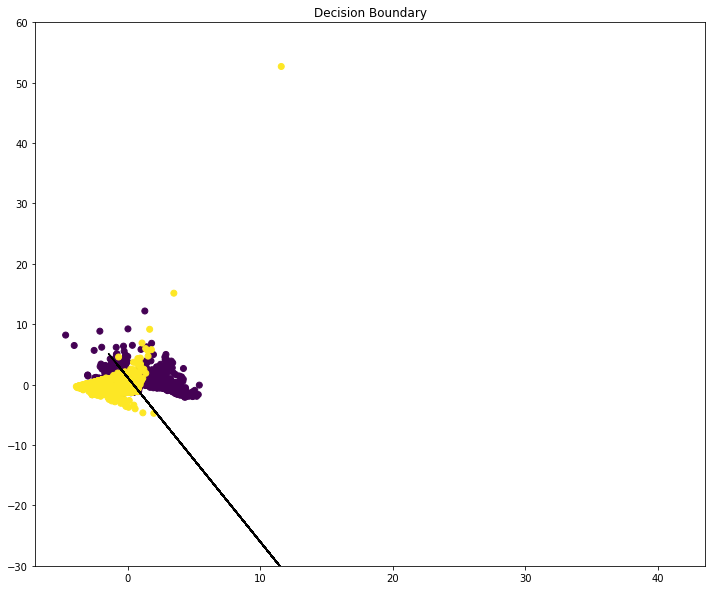

In [129]:
plt.figure(figsize=(12,10))
plt.scatter(x_train_us_pca[:, 2], x_train_us_pca[:, 3], c=y_train_us[:])
y_vals_2 = intercept_R + (slope_R * x_train_us_pca[:, 0])
plt.plot(x_train_us_pca[:, 0], y_vals_2, c="k")
plt.title('Decision Boundary')
plt.ylim((-30, 60))
plt.show()

In [130]:
pred_R = rg_R.predict(x_test_us_pca)

In [131]:
precision_R = precision_score(y_test, pred_R)
precision_R

0.0040138083446073355

In [132]:
print(classification_report(y_test,pred_R))

              precision    recall  f1-score   support

           0       1.00      0.70      0.83   1270881
           1       0.00      0.93      0.01      1643

    accuracy                           0.70   1272524
   macro avg       0.50      0.81      0.42   1272524
weighted avg       1.00      0.70      0.82   1272524



### 2. Random Forest

Hacemos una búsqueda de un buen modelo a partir de variaciones en los hiperparámetros. En esta primera búsqueda usamos el dataset que pasamos por PCA.

In [133]:
classifier = RandomForestClassifier()

parameters = {
        'n_estimators' : range(4,16), 
        'criterion' : ['entropy'],
        'max_depth' : range(2,11)
}

rand_est = RandomizedSearchCV(classifier, parameters, n_iter =100, cv = 5, scoring ='neg_log_loss').fit(x_train_us_pca,y_train_us)

Obtenemos los mejores parámetros para la búsqueda.

In [134]:
print(rand_est.best_estimator_)
print(rand_est.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=12)
{'n_estimators': 12, 'max_depth': 10, 'criterion': 'entropy'}


In [136]:
pred_rf= rand_est.predict(x_test_us_pca)

In [137]:
precission_rf = precision_score(y_test, pred_rf)
precission_rf

0.028863523573200992

In [138]:
accuracy_score(y_test, pred_rf)

0.9614074076402488

In [139]:
print(classification_report(y_test,pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.88      0.06      1643

    accuracy                           0.96   1272524
   macro avg       0.51      0.92      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524



Hacemos una segunda búsqueda con el dataset sin PCA.

In [140]:
classifier_2 = RandomForestClassifier()

parameters = {
        'n_estimators' : range(4,16), 
        'criterion' : ['entropy'],
        'max_depth' : range(2,11)
}

rand_est_2 = RandomizedSearchCV(classifier_2, parameters, n_iter =100, cv = 5, scoring ='neg_log_loss').fit(X_train_us, y_train_us)

In [141]:
print(rand_est_2.best_estimator_)
print(rand_est_2.best_params_)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=12)
{'n_estimators': 12, 'max_depth': 10, 'criterion': 'entropy'}


In [143]:
pred_rf_2= rand_est_2.predict(X_test)

In [144]:
precission_rf = precision_score(y_test, pred_rf_2)
precission_rf

0.04883087332714589

In [145]:
print(classification_report(y_test,pred_rf_2))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270881
           1       0.05      0.99      0.09      1643

    accuracy                           0.98   1272524
   macro avg       0.52      0.98      0.54   1272524
weighted avg       1.00      0.98      0.99   1272524



### 3. Support Vector Machine

Vamos a entrenar un modelo de SVM no lineal con PCA. 

In [146]:
svm = SVC(C=50, kernel="rbf")
svm.fit(x_train_us_pca,y_train_us)

SVC(C=50)

In [147]:
y_pred_svc =svm.predict(x_test_us_pca)

In [148]:
print("Score the X-train with Y-train is : ", svm.score(x_train_us_pca,y_train_us))
print("Score the X-test  with Y-test  is : ", svm.score(x_test_us_pca, y_test))
print(" Model Evaluation SVC : accuracy score " , accuracy_score(y_test,y_pred_svc))

Score the X-train with Y-train is :  0.9164383561643835
Score the X-test  with Y-test  is :  0.9585493083038119
 Model Evaluation SVC : accuracy score  0.9585493083038119


In [149]:
print(classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.87      0.05      1643

    accuracy                           0.96   1272524
   macro avg       0.51      0.91      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524



Ahora vamos a entrenar sin PCA.

In [152]:
X_train_scaled = scaler.fit_transform(X_train_us)
X_test_scaled = scaler.transform(X_test)

In [154]:
svm_2 = SVC(C=50, kernel="rbf")
svm_2.fit(X_train_scaled,y_train_us)

SVC(C=50)

In [156]:
y_pred_svc_2 =svm.predict(X_test_scaled)

In [157]:
print("Score the X-train with Y-train is : ", svm.score(X_train_scaled,y_train_us))
print("Score the X-test  with Y-test  is : ", svm.score(X_test_scaled, y_test))
print(" Model Evaluation SVC : accuracy score " , accuracy_score(y_test,y_pred_svc_2))

Score the X-train with Y-train is :  0.9644596651445967
Score the X-test  with Y-test  is :  0.9706449544370086
 Model Evaluation SVC : accuracy score  0.9706449544370086


In [158]:
print(classification_report(y_test,y_pred_svc_2))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99   1270881
           1       0.04      0.96      0.08      1643

    accuracy                           0.97   1272524
   macro avg       0.52      0.96      0.53   1272524
weighted avg       1.00      0.97      0.98   1272524



## Primeras conclusiones

Después de entrenar dos modelos diferentes de regresión (uno con Ridge y otro con Lasso) y dos búsquedas para Random Forest (una con PCA y otra sin PCA), la primera pregunta que me surgió fue ¿Por qué estoy obteniendo tan bajos puntajes en precision y buenos putajes en Accuracy?

Cuando veo la precisión para ambas clases, a todos los modelos les cuesta lograr un buen score de precisión para la clase minoritaria. Sin embargo, como la clase mayoritaria la clasifica muy bien, el accuracy tiende a tener puntajes altos porque el accuracy para la clase mayoritaria es alto. Esto quiere decir que en principio, para dataset desvalanceados el promedio del accuracy no es una buena métrica, resulta mejor ver la precisión para cada clase y el accuracy para cada clase. 